<a href="https://colab.research.google.com/github/manishmawatwal/DataScience/blob/main/Predicting_trajectories_of_atlantic_hurricanes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install geopandas

In [2]:
from google.colab import files
uploaded=files.upload()

Saving atlantic.csv to atlantic (1).csv


In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import copy
warnings.simplefilter('ignore')
plt.style.use('bmh')

In [4]:
df = pd.read_csv('atlantic.csv')
df.head(5)

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,0,,HU,28.0N,94.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,18510625,600,,HU,28.0N,95.4W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,18510625,1200,,HU,28.0N,96.0W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,18510625,1800,,HU,28.1N,96.5W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2N,96.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [5]:
#convert time from 0hrs,600hrs,1200hrs to 00:00:00 and so on
df['Time'] = df['Time'].astype('object')
time_replace = [str(x) for x in df['Time'].unique()]
for i, txt in enumerate(time_replace):
    time_replace[i] = txt.rjust(4, '0')
    time_replace[i] = f'{time_replace[i][0:2]}:{time_replace[i][2:4]}:00'
for old, new in zip(df['Time'].unique(), time_replace):
    df.loc[df['Time'] == old, 'Time'] = new

In [6]:
df.head(5)

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,00:00:00,,HU,28.0N,94.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,18510625,06:00:00,,HU,28.0N,95.4W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,18510625,12:00:00,,HU,28.0N,96.0W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,18510625,18:00:00,,HU,28.1N,96.5W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,18510625,21:00:00,L,HU,28.2N,96.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [7]:
#convert date like 18510625 to 1851-06-25
df['Date'] = df['Date'].astype('object')
for i, date_str in enumerate(df['Date'].unique()):
    df.loc[df['Date'] == date_str, 'Date'] = f'{str(date_str)[0:4]} - {str(date_str)[4:6]} - {str(date_str)[6:]}'

In [8]:
df.head(5)

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,1851 - 06 - 25,00:00:00,,HU,28.0N,94.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,1851 - 06 - 25,06:00:00,,HU,28.0N,95.4W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,1851 - 06 - 25,12:00:00,,HU,28.0N,96.0W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,1851 - 06 - 25,18:00:00,,HU,28.1N,96.5W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,1851 - 06 - 25,21:00:00,L,HU,28.2N,96.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [9]:
#add date and time together
df['Datetime'] = df['Date']+' '+df['Time']
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.drop(columns=['Date', 'Time'], inplace=True)
df.sort_values(by=['Datetime'], inplace=True)

In [10]:
df.head(3)

,ID,Name,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Datetime
0,AL011851,UNNAMED,,HU,28.0N,94.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851-06-25 00:00:00
1,AL011851,UNNAMED,,HU,28.0N,95.4W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851-06-25 06:00:00
2,AL011851,UNNAMED,,HU,28.0N,96.0W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851-06-25 12:00:00


In [11]:
#remove any unwanted spaces at the beginning and end of the columns
df['Name'] = df['Name'].str.strip()
df['Status'] = df['Status'].str.strip()
df['Event'] = df['Event'].str.strip()

In [12]:
df.head(3)

,ID,Name,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Datetime
0,AL011851,UNNAMED,,HU,28.0N,94.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851-06-25 00:00:00
1,AL011851,UNNAMED,,HU,28.0N,95.4W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851-06-25 06:00:00
2,AL011851,UNNAMED,,HU,28.0N,96.0W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851-06-25 12:00:00


In [13]:
#use double quotes instead of single
print(f"Dataset contains data of {df['ID'].unique().shape[0]} individual storms from {df['Datetime'].dt.year.min()} to {df['Datetime'].dt.year.max()}.")

Dataset contains data of 1814 individual storms from 1851 to 2015.


In [14]:
def coordinate_mapping(x):
    coord = float(x[:-1])
    if x[-1] == 'W':
        coord *= -1
    if x[-1] == 'S':
        coord *= -1
    return coord

df['Latitude'] = df['Latitude'].apply(coordinate_mapping)
df['Longitude'] = df['Longitude'].apply(coordinate_mapping)

In [15]:
df.head(3)

,ID,Name,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Datetime
0,AL011851,UNNAMED,,HU,28.0,-94.8,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851-06-25 00:00:00
1,AL011851,UNNAMED,,HU,28.0,-95.4,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851-06-25 06:00:00
2,AL011851,UNNAMED,,HU,28.0,-96.0,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851-06-25 12:00:00


In [16]:
print('Min. Long.:', df.Longitude.min(), 'Max. Long', df.Longitude.max(), 'Min. Lat.:', df.Latitude.min(), 'Max. Lat.:', df.Latitude.max())

Min. Long.: -359.1 Max. Long 63.0 Min. Lat.: 7.2 Max. Lat.: 81.0


A minimum longitude of -359.1 makes no sense as the scale is between 180 and -180, so we have to rotate these values.

In [17]:
df.loc[df.Longitude <- 180, 'Longitude'] = df.Longitude + 360

In [18]:
print('Min. Long.:', df.Longitude.min(), 'Max. Long', df.Longitude.max(), 'Min. Lat.:', df.Latitude.min(), 'Max. Lat.:', df.Latitude.max())

Min. Long.: -109.5 Max. Long 63.0 Min. Lat.: 7.2 Max. Lat.: 81.0


In [19]:
gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.Longitude, df.Latitude), crs = {'init' : 'epsg:4326'})
gdf.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [20]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

KeyError: ignored

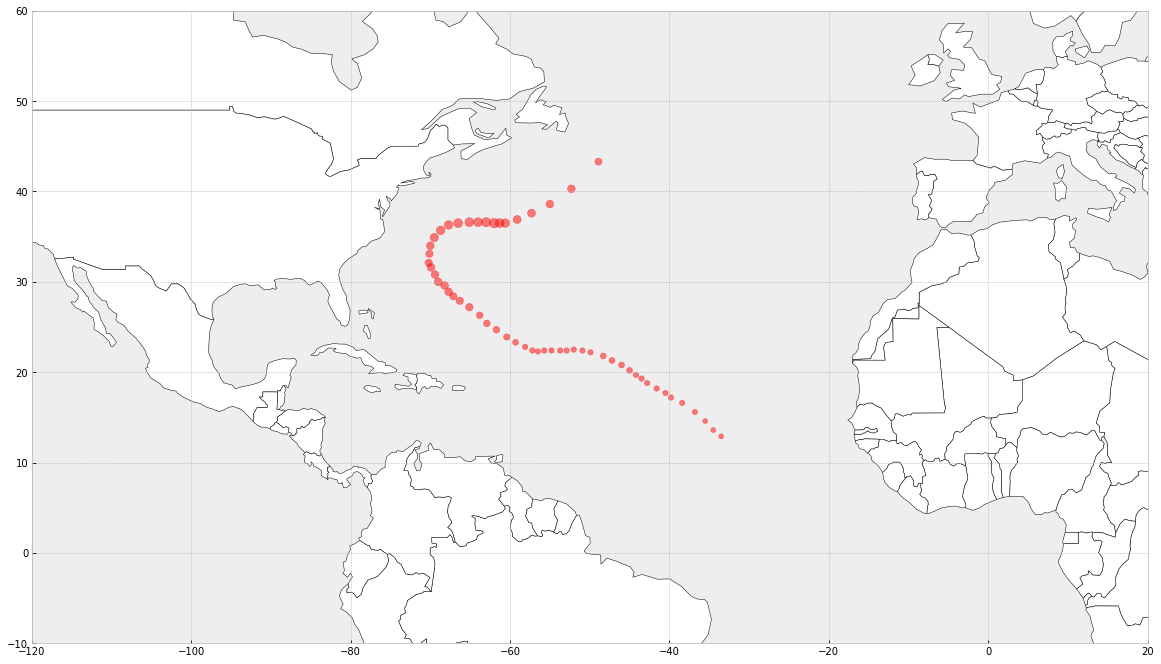

In [22]:
ax = world.plot(color='white', edgecolor='black', figsize=(20,15))
_ = gdf[gdf['ID'] == 'AL092005'].plot(ax=ax, c='r', markersize='Maximum Wind', alpha=0.5)
_ = plt.xlim(-120, 20)
_ = plt.ylim(-10, 60)
_ = plt.title(f"{gdf[['ID'] == 'AL092005'].Name.unique()[0]}({gdf[gdf['ID'] == 'AL092005'].Datetime.dt.year.unique()[0]})")

To make predictions i'll construct a simplified coordinate system where the latitude is the x axis and longitude is the y axis and the positions of all storms are between 0 and 1.

In [23]:
lat_min = gdf.Latitude.min()
long_min = gdf.Longitude.min()
gdf['x'] = gdf.Latitude - lat_min
gdf['x'] = gdf['x'] / gdf['x'].max()
gdf['y'] = gdf.Longitude - long_min
gdf['y'] = gdf['y'] / gdf['y'].max()

The month and season is an important feature because this contains implicit information such as the water temperature. A continous number is much easier to work with than with months/days etc. so i'll create a feature where the first of january corresponds to 0 and the 31th of december corresponds to 1.
Additionally i'll create a feature "Month of year" and "Hour of day".

Each day is 1/366 of a year (with 31th of december), each hour is a 1/24 of a day and each minute 1/60 of a hour.

In [24]:
gdf['relative_time'] = ((gdf.Datetime.dt.dayofyear + (gdf.Datetime.dt.hour)/24. + (gdf.Datetime.dt.minute/60.*24))/366.)

In [25]:
gdf['month'] = gdf.Datetime.dt.month
gdf['hour'] = gdf.Datetime.dt.hour

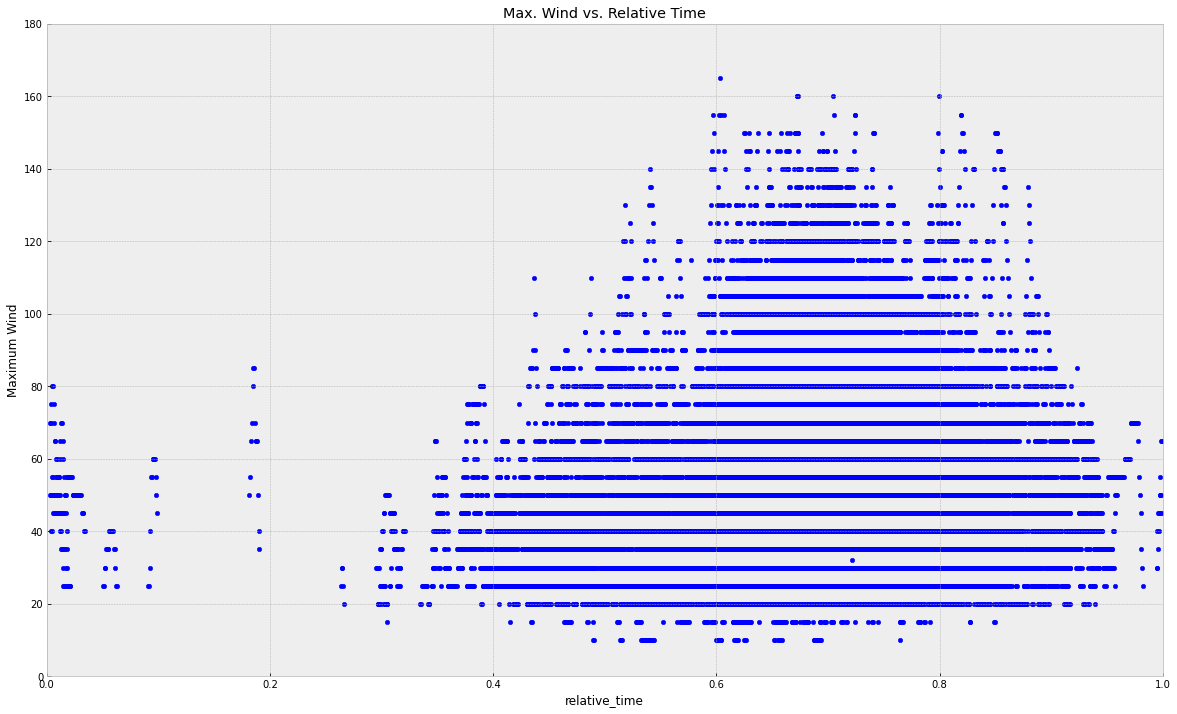

In [26]:
_ = gdf.plot(x = 'relative_time', y = 'Maximum Wind', kind = 'scatter', figsize = (20,12), title = 'Max. Wind vs. Relative Time')
_ = plt.ylim(0,180)
_ = plt.xlim(0,1)

We'll try to predict the next position in the storm trajectory. To be able to do this we need to calculate the vectors for each positional change.

In [27]:
gdf['vec_x'] = np.nan
gdf['vec_y'] = np.nan
vecs = {'x': [], 'y': [], 'id': []}
for storm_id in gdf['ID'].unique():
    last_x = 0
    last_y = 0
    for i, row in gdf[gdf['ID'] == storm_id].iterrows():
        if last_x == 0:
            last_x = row.x
            last_y = row.y
        else:
            vec_x = row.x - last_x
            vec_y = row.y - last_y
            vecs['x'].append(vec_x)
            vecs['y'].append(vec_y)
            vecs['id'].append(i)
            last_x = row.x
            last_y = row.y
gdf.loc[vecs['id'], 'vec_x'] = vecs['x']
gdf.loc[vecs['id'], 'vec_y'] = vecs['y']

Because we can only predict one value we'll need two models to predict the trajectory. As the independent prediction of the x and y position probably won't work i'll use one model to predict the change in direction (angle) and the change in distance (length).

In [28]:
gdf['vec_len'] = np.sqrt((gdf['vec_x']**2)+(gdf['vec_y']**2))

In [29]:
def calculate_direction(vec_x, vec_y):
    def vec_angle(a, b):
        return np.arccos(np.dot(a,b) / (np.linalg.norm(a)* np.linalg.norm(b)))
    ref_vec = np.array([vec_x, vec_y])
    N_vec = np.array([0,1])
    S_vec = np.array([0,-1])
    E_vec = np.array([1,0])
    W_vec = np.array([-1,0])
    N_angle = vec_angle(ref_vec, N_vec)
    E_angle = vec_angle(ref_vec, E_vec)
    W_angle = vec_angle(ref_vec, W_vec)
    return_angle = N_angle
    if W_angle < E_angle:
        return_angle = 2*np.pi - return_angle
    return return_angle

In [30]:
gdf['vec_direction'] = gdf.apply(lambda x: calculate_direction(x.vec_x, x.vec_y), axis = 1)

In [31]:
gdf['tdelta'] = np.nan
tdeltas = {'t': [], 'id': []}
for storm_id in gdf['ID'].unique():
    last_time = 0
    for i, row in gdf[gdf['ID'] == storm_id].iterrows():
        if last_time == 0:
            last_time = row.Datetime
        else:
            tdeltas['t'].append((row.Datetime - last_time).seconds)
            tdeltas['id'].append(i)
            last_time = row.Datetime
gdf.loc[tdeltas['id'], 'tdelta'] = tdeltas['t']

In [32]:
gdf = gdf[gdf['tdelta'] == 21600]
gdf.shape

(45717, 32)

In [33]:
gdf['prev_len'] = np.nan
gdf['prev_direction'] = np.nan
prevs = {'len': [], 'direction': [], 'id': []}
for storm_id in gdf['ID'].unique():
    last_len = False
    last_direction = False
    for i, row in gdf[gdf['ID'] == storm_id].iterrows():
        if last_len == False:
            last_len = row.vec_direction
        else:
            prevs['len'].append(last_len)
            prevs['direction'].append(last_direction)
            prevs['id'].append(i)
            last_len = row.vec_len
            last_direction = row.vec_direction
gdf.loc[prevs['id'], 'prev_len'] = prevs['len']
gdf.loc[prevs['id'], 'prev_direction'] = prevs['direction']

In [34]:
gdf.dropna(how='any', inplace = True)
gdf.shape

(43683, 34)

The hypothesis for both models (distance traveled, direction) depends on the following features:

1. Maximum Wind: The highest measured windspeed
2. Position (x, y): Probably the most important feature, as storms behave similary in the gulf etc. (my hope is, that the models create some kind of artifical grid, e.g. if x>0.1 and x < 0.2 etc., even though that requires A LOT of splits)
3. Month of year: A latent variable for the genereal climatic conditions (Temperature, Jet stream etc.)
4. Hour of day: A latent variable for temperature (usually the temperature at 12am is different than at 2am etc.)
5. Previous distance/direction

In [35]:
gdf_prediction_direction = gdf[['Maximum Wind', 'x', 'y', 'month', 'hour', 'prev_len', 'prev_direction', 'vec_direction']]
gdf_prediction_length = gdf[['Maximum Wind', 'x', 'y', 'month', 'hour', 'prev_len', 'prev_direction', 'vec_len']]
X_direction = gdf_prediction_direction.values[:,:-1]
y_direction = gdf_prediction_direction.values[:,-1]
X_length = gdf_prediction_length.values[:,:-1]
y_length = gdf_prediction_length.values[:,-1]

In [36]:
from sklearn.model_selection import train_test_split
X_direction_train, X_direction_test, y_direction_train, y_direction_test = train_test_split(X_direction, y_direction, test_size = 0.2, random_state = 42)
X_length_train, X_length_test, y_length_train, y_length_test = train_test_split(X_length, y_length, test_size = 0.2, random_state = 42)

In [37]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [38]:
model_direction = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 5, random_state =0, loss = 'ls').fit(X_direction_train, y_direction_train)
mean_squared_error(y_direction_test, model_direction.predict(X_direction_test))

0.37171190331386467

In [39]:
model_length = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 5, random_state = 0, loss = 'ls').fit(X_length_train, y_length_train)
mean_squared_error(y_length_test, model_length.predict(X_length_test))

1.4598824379865422e-05

In [40]:
#import only this version of shap as others are not supported on google colab
!pip install shap==0.39.0

In [41]:
import shap

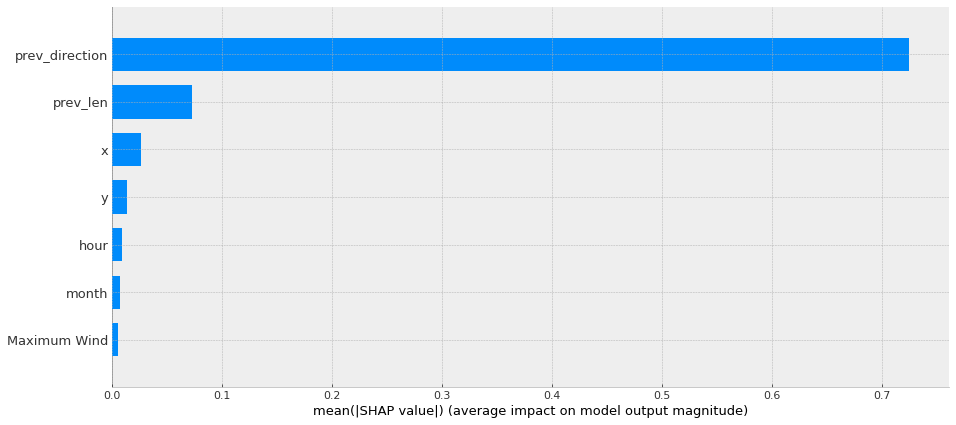

In [54]:
#Let's look at the feature importances
explainer_direction = shap.TreeExplainer(model_direction)
shap_values_direction = explainer_direction.shap_values(X_direction_test)
shap.summary_plot(shap_values_direction, X_direction_test, plot_type = 'bar', feature_names = ['Maximum Wind', 'x', 'y', 'month', 'hour', 'prev_len', 'prev_direction'], title='Feature importances model_direction', plot_size = (15,7))

As expected the previous direction has a huge influence, followed by the latitude and the previous distance.

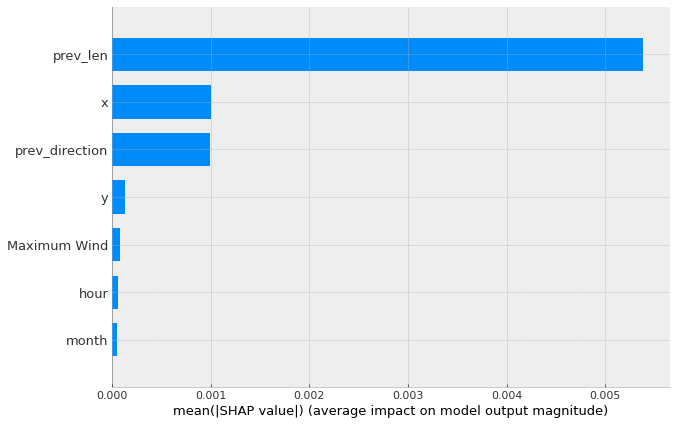

In [55]:
explainer_length = shap.TreeExplainer(model_length)
shap_values_length = explainer_length.shap_values(X_length_test)
shap.summary_plot(shap_values_length, X_length_test, plot_type="bar", feature_names=["Maximum Wind", "x", "y", "month", "hour", "prev_len", "prev_direction"], title="Feature importances model_length", plot_size=(10,7))

For the distance/length prediction the previous value is the most important one, too.

In [43]:
lat_min = df.Latitude.min()
long_min = df.Longitude.min()
temp_x = df.Latitude-lat_min
temp_y = df.Longitude-long_min
x_max = temp_x.max()
y_max = temp_y.max()

def coords_to_latlong(x, y, lat_min, long_min, x_max, y_max):
    return (x*x_max)+lat_min, (y*y_max)+long_min

In [56]:
gdf[gdf.Name=="BECKY"].ID.unique()

array(['AL021958', 'AL021962', 'AL021966', 'AL021970', 'AL091974'],
      dtype=object)

In [57]:
storm_id = "AL021958"
gdf_pred = gdf[["Latitude", "Longitude", "Maximum Wind", "x", "y", "month", "hour", "prev_len", "prev_direction", "vec_len", "vec_direction"]][gdf.ID==storm_id]
X_pred_direction = gdf_pred[["Maximum Wind", "x", "y", "month", "hour", "prev_len", "prev_direction"]].iloc[1:].values
X_pred_len = gdf_pred[["Maximum Wind", "x", "y", "month", "hour", "prev_len", "prev_direction"]].iloc[1:].values

In [58]:
df_pred = pd.DataFrame({"pred_len": model_length.predict(X_pred_len), "pred_direction": model_direction.predict(X_pred_direction)})

In [59]:
df_pred["pred_x"] = np.nan
df_pred["pred_y"] = np.nan
df_pred["real_x"] = gdf_pred["x"].iloc[1:].values
df_pred["real_y"] = gdf_pred["y"].iloc[1:].values

In [60]:
last_x = gdf_pred["x"].iloc[0]
last_y = gdf_pred["y"].iloc[0]
coords = {"x": [], "y": [], "id": []}
for i, row in df_pred.iterrows():
    vector = np.array([0,1])
    R = np.array([[np.cos(row.pred_direction), -np.sin(row.pred_direction)], [np.sin(row.pred_direction), np.cos(row.pred_direction)]])
    vector = np.matmul(vector, R)
    vector = vector/np.linalg.norm(vector)
    vector *= row.pred_len
    coords["x"].append(last_x+vector[0])
    coords["y"].append(last_y+vector[1])
    coords["id"].append(i)
    last_x = row.real_x
    last_y = row.real_y
df_pred.loc[coords["id"], "pred_x"] = coords["x"]
df_pred.loc[coords["id"], "pred_y"] = coords["y"]

In [61]:
df_pred["pred_Longitude"] = np.nan
df_pred["real_Longitude"] = np.nan
df_pred["pred_Latitude"] = np.nan
df_pred["real_Latitude"] = np.nan
latslongs = {"pred_Longitude": [], "real_Longitude": [], "pred_Latitude": [], "real_Latitude": [], "id": []}
for i, row in df_pred.iterrows():
    real_Latitude, real_Longitude = coords_to_latlong(row.real_x, row.real_y, lat_min, long_min, x_max, y_max)
    latslongs["real_Latitude"].append(real_Latitude)
    latslongs["real_Longitude"].append(real_Longitude)
    pred_Latitude, pred_Longitude = coords_to_latlong(row.pred_x, row.pred_y, lat_min, long_min, x_max, y_max)
    latslongs["pred_Latitude"].append(pred_Latitude)
    latslongs["pred_Longitude"].append(pred_Longitude)
    latslongs["id"].append(i)
df_pred.loc[latslongs["id"], "real_Latitude"] = latslongs["real_Latitude"]
df_pred.loc[latslongs["id"], "real_Longitude"] = latslongs["real_Longitude"]
df_pred.loc[latslongs["id"], "pred_Latitude"] = latslongs["pred_Latitude"]
df_pred.loc[latslongs["id"], "pred_Longitude"] = latslongs["pred_Longitude"]

In [62]:
df_pred

,pred_len,pred_direction,pred_x,pred_y,real_x,real_y,pred_Longitude,real_Longitude,pred_Latitude,real_Latitude
0,0.009341,2.779517,0.134745,0.490975,0.135501,0.489855,-24.806870,-25.0,17.144187,17.2
1,0.010685,2.693743,0.140128,0.480223,0.138211,0.479420,-26.661465,-26.8,17.541481,17.4
2,0.010697,2.810828,0.141685,0.469303,0.139566,0.468986,-28.545220,-28.6,17.656384,17.5
3,0.010109,2.967536,0.141317,0.459029,0.139566,0.458551,-30.317523,-30.4,17.629204,17.5
4,0.010115,3.070801,0.140282,0.448461,0.139566,0.448116,-32.140482,-32.2,17.552802,17.5
5,0.010247,3.060418,0.140397,0.437903,0.139566,0.437681,-33.961743,-34.0,17.561317,17.5
6,0.010202,3.047500,0.140525,0.427524,0.139566,0.427246,-35.752116,-35.8,17.570741,17.5
7,0.010174,3.070801,0.140286,0.417098,0.139566,0.415072,-37.550569,-37.9,17.553108,17.5
8,0.012222,3.070801,0.140431,0.402881,0.140921,0.402899,-40.003025,-40.0,17.563800,17.6
9,0.012232,2.965801,0.143061,0.390855,0.142276,0.391304,-42.077558,-42.0,17.757879,17.7


In [63]:
gdf_real = gpd.GeoDataFrame(df_pred,geometry=gpd.points_from_xy(df_pred.real_Longitude,df_pred.real_Latitude), crs={'init' :'epsg:4326'})
gdf_pred = gpd.GeoDataFrame(df_pred,geometry=gpd.points_from_xy(df_pred.pred_Longitude,df_pred.pred_Latitude), crs={'init' :'epsg:4326'})

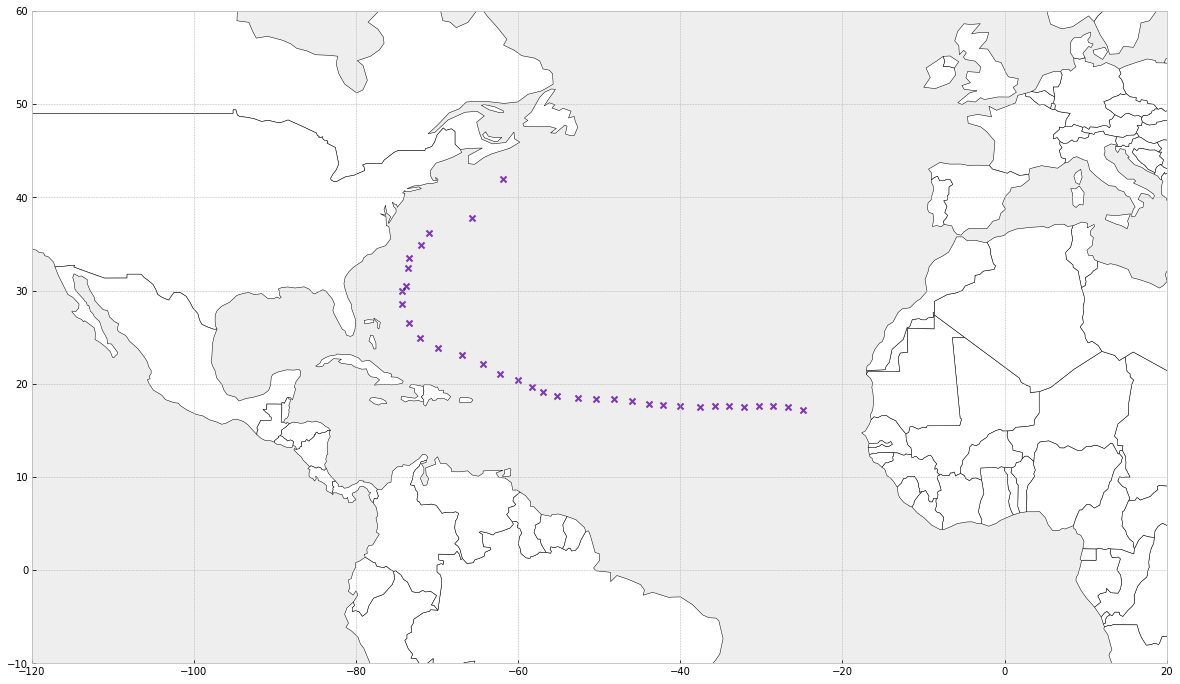

In [64]:
ax = world.plot(color="white", edgecolor="black", figsize=(25,12))
_ = gdf_real.plot(ax=ax, c="r", marker="x", alpha=0.5)
_ = gdf_pred.plot(ax=ax, c="b", marker="x", alpha=0.5)
_ = plt.xlim(-120, 20)
_ = plt.ylim(-10, 60)